<a href="https://colab.research.google.com/github/Se1towo/IMLO_Exam/blob/main/IMLO_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy.io
import csv

In [2]:
width = 224
height = 224

In [3]:
# transform=transforms.Compose([
#     #transforms.Pad(padding=(100, 100)),
#     transforms.Resize((width,height)),
#     transforms.ToTensor()
# ])
transform = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.Resize((width,height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
training_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)
print("Training data:", training_data)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)
print("Testing data:", test_data)

100%|██████████| 344862509/344862509 [00:12<00:00, 27896671.39it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 533723.86it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15207649.41it/s]


In [5]:
learning_rate = 1e-3
batch_size = 64
epochs = 100

In [6]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

<ipython-input-7-bc4dc9832fd3>:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  plt.imshow(img.squeeze().T)


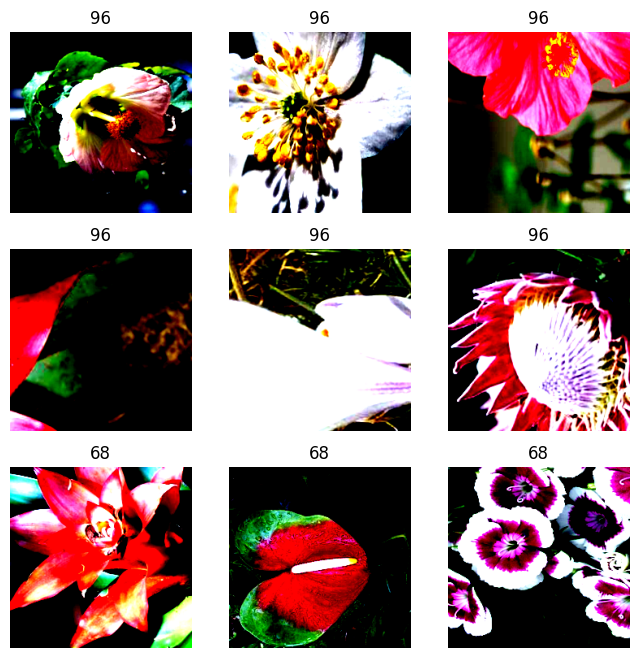

In [7]:
labels_map = {}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if label not in labels_map:
      labels_map[label] = img
    figure.add_subplot(rows, cols, i)
    plt.title(list(labels_map.keys())[i % len(labels_map)])
    plt.axis("off")
    plt.imshow(img.squeeze().T)
plt.show()

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


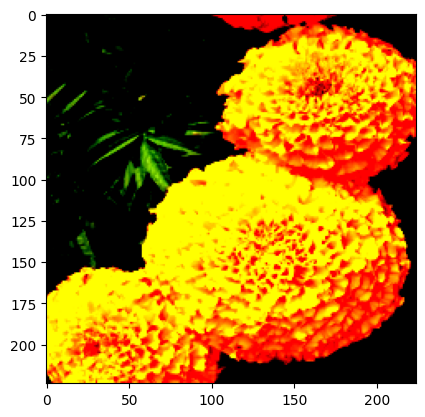

Label: 46


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].T.squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# import math

# def conv_out(in_size, k, s, p):
#     return math.floor(((in_size + 2*p - k) / s) + 1)

# def maxpool_out(in_size, k, s):
#     return math.floor(((in_size - k) / s) + 1)

# sizes = 500
# sizes = conv_out(sizes, 7, 4, 2)
# sizes = conv_out(sizes, 5, 1, 2)
# for _ in range(5): # conv2ds=5 excluding first 2
#     sizes = conv_out(sizes, 3, 1, 1)
# for _ in range(3): # maxpools=3
#     sizes = maxpool_out(sizes, 3, 2)

# print("sizes:", sizes)


In [10]:
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pooling_stack = nn.Sequential(
            # Convolutional Layer
            nn.Conv2d(in_channels=3, out_channels=102, kernel_size=11, stride=4, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(102),
            # Activation Layer
            nn.ReLU(inplace=True),
            # Pooling Layer
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(102, 256, kernel_size=5, padding=2),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            # # Batch Normalization
            # nn.BatchNorm2d(384),
            # nn.LeakyReLU(inplace=True),
            # nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(384),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            # Batch Normalization
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            # Fully connected layers
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Regularization
            nn.Dropout(),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.conv_pooling_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [11]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [12]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        correct += (pred.argmax(1) == y).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_accuracy = 100.0 * correct / size
    print(f"Training Accuracy: {train_accuracy:.2f}%\n")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= size
    test_accuracy = 100.0 * correct / size
    print(f"Validation Error: \n Accuracy: {test_accuracy:>0.2f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Training loss: 4.666253  [   64/ 1020]
Training Accuracy: 1.08%

Validation Error: 
 Accuracy: 1.06%, Avg loss: 0.072927 

Epoch 2
-------------------------------
Training loss: 4.608521  [   64/ 1020]
Training Accuracy: 1.18%

Validation Error: 
 Accuracy: 1.28%, Avg loss: 0.072768 

Epoch 3
-------------------------------
Training loss: 4.704803  [   64/ 1020]
Training Accuracy: 1.37%

Validation Error: 
 Accuracy: 1.68%, Avg loss: 0.072602 

Epoch 4
-------------------------------
Training loss: 4.600830  [   64/ 1020]
Training Accuracy: 0.88%

Validation Error: 
 Accuracy: 2.20%, Avg loss: 0.072486 

Epoch 5
-------------------------------
Training loss: 4.621392  [   64/ 1020]
Training Accuracy: 0.98%

Validation Error: 
 Accuracy: 2.24%, Avg loss: 0.072435 

Epoch 6
-------------------------------
Training loss: 4.683245  [   64/ 1020]
Training Accuracy: 1.08%

Validation Error: 
 Accuracy: 2.57%, Avg loss: 0.072341 

Epoch 7
--------------

In [16]:
import torchvision.models as models
torch.save(model.state_dict(), 'model_weights.pth')
print("Saved PyTorch Model State to model_weights.pth")

Saved PyTorch Model State to model_weights.pth


In [19]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

NeuralNetwork(
  (conv_pooling_stack): Sequential(
    (0): Conv2d(3, 102, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(102, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [20]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

In [21]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/final_model.pth')

In [22]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')